## 1. Import thư viện

In [1]:
from google.colab import drive # lấy file dataset từ Drive

drive.mount('/content/drive')
print("Đã kết nối Google Drive thành công.")

Mounted at /content/drive
Đã kết nối Google Drive thành công.


In [2]:
import pandas as pd # xử lý dữ liệu dạng bảng (CSV/Excel)
from sklearn.model_selection import train_test_split # chia dữ liệu train/test
from sklearn.preprocessing import LabelEncoder # biến nhãn chữ thành số

from sklearn.pipeline import Pipeline # xâu chuỗi bước xử lý + model
from sklearn.feature_extraction.text import TfidfVectorizer # biến text thành vector số (TF-IDF)

from sklearn.linear_model import LogisticRegression # mô hình phân loại (Logistic Regression)

from sklearn.metrics import (
    accuracy_score, # độ chính xác
    classification_report, # báo cáo precision, recall, f1-score
    confusion_matrix, # ma trận nhầm lẫn
    ConfusionMatrixDisplay # vẽ trực quan confusion matrix
)

import matplotlib.pyplot as plt # vẽ biểu đồ cơ bản
import seaborn as sns # vẽ biểu đồ nâng cao hơn

## 2. Lấy dữ liệu từ Drive

In [3]:
FILE_PATH = '/content/drive/MyDrive/[Tự học Machine Learning]/Sentiment_Analysis/sentiment_dataset_10000_v2.csv'

try:
  df = pd.read_csv(FILE_PATH)
  print("Đã lấy dữ liệu thành công.")
  print("-" * 30)
  print(f"Tổng số mẫu được tải lên: {len(df)}")
  print("5 hàng đầu tiên của Dataframe:")
  print(df.head())
except FileNotFoundError:
  print(f"LỖI: Không tìm thấy file tại đg dẫn sau")
  print(f"    {FILE_PATH}")
  print("Vui lòng kiểm tra lại tên file và đường dẫn trong Drive")

Đã lấy dữ liệu thành công.
------------------------------
Tổng số mẫu được tải lên: 10000
5 hàng đầu tiên của Dataframe:
   ID                                               Text     Label
0   1             Thwas decision brought me so much joy.  Positive
1   2  This gadget is a game-changer for my daily rou...  Positive
2   3           This so purchase brought me so much joy.  Positive
3   4  Thseemed company sets a new standard for quality.  Positive
4   5    The staff was lazy and unmotivated.. Stay away.  Negative


## 3. Tiền xử lý dữ liệu

### 3.1. Làm sạch và chuẩn hoá dữ liệu

In [4]:
# kiểm tra file có đủ 2 cột bắt buộc ko
assert set(["Text", "Label"]).issubset(df.columns)

df = df.dropna(subset=["Text", "Label"]).copy() # bỏ dòng thiếu
df["Text"] = df["Text"].astype(str).str.strip() # chuẩn hoá test (xoá khoảng trắng thừa)
df["Label"] = df["Label"].astype(str).str.strip().str.lower() # chuẩn hoá nhãn

# chỉ để 2 nhãn chính là positive/negative
df = df[df["Label"].isin(["positive", "negative"])].copy()

# kiểm tra dataset size và phân bố nhãn
print("Tổng số mẫu", len(df))
print("Phân bố nhãn:")
print(df["Label"].value_counts())


Tổng số mẫu 10000
Phân bố nhãn:
Label
positive    5000
negative    5000
Name: count, dtype: int64


### 3.2. Mã hoá nhãn

In [ ]:
# mã hoá nhãn chữ (positive / negative) thành số (0/1)
encoder = LabelEncoder()
y = encoder.fit_transform(df["Label"]) # vừa học mapping vừa trả về mảng số

### LabelEncoder() mapping theo bảng chữ cái
- "negative" -> 0
- "positive" -> 1

## 4. Xử lý dữ liệu



### 4.1. Chia tập train/test

In [6]:
# Chia dữ liệu thành train (80%) và test (20%)
X = df['Text']

X_train , X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.80, # 80% train, 20% test
    stratify=y,      # giữ tỉ lệ nhãn cân bằng
    shuffle=True,    # xáo trộn trước khi chia
    random_state=42  # để kết quả tái lập
)

print("Kích thước tập train", len(X_train))
print("Kích thước tập test", len(X_test))


Kích thước tập train 8000
Kích thước tập test 2000


In [7]:
# Đếm số lượng mỗi nhãn (0 = negative, 1 = positive)
print(pd.Series(y).value_counts())

1    5000
0    5000
Name: count, dtype: int64


### 4.2. TF-IDF Vectorizer

In [8]:
# Chuyển văn bản thành vector số bằng TF-IDF
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),     # dùng unigram + bigram để hiểu cụm từ
    min_df = 2,            # bỏ từ quá hiếm (xuất hiện <2 lần)
    max_features=20000,    # giới hạn số đặc trưng để giảm nhiễu/ghi nhớ
    stop_words='english',  # bỏ các từ dừng (a, the, is...)
    sublinear_tf=True      # dùng log-scale TF để ổn định giá trị
)

# Biến đổi tập train thành ma trận TF-IDF
X_train = vectorizer.fit_transform(X_train)

# Biến đồi tập test dùng cùng vectorizer (không fit lại)
X_test = vectorizer.transform(X_test)

# Lưu nhãn gốc (chữ) nếu cần cho các bước đánh giá sau này
y = df["Label"]

## 5. Huấn luyện mô hình

In [9]:
# Khởi tạo mô hình Logistic Regression
model = LogisticRegression()

# Huấn luyện mô hình trên tập train
# X_train: đặc trưng TF-IDF , y_train: nhãn số
model.fit(X_train, y_train)

print("Đã huấn luyện mô hình thành công")

Đã huấn luyện mô hình thành công


## 6. Đánh giá mô hình

=== Logistic Regression (train 80% / test 20%) ===
Accuracy: 1.0
----------------------------------------------------------------------------------------------------
Confusion Matrix:


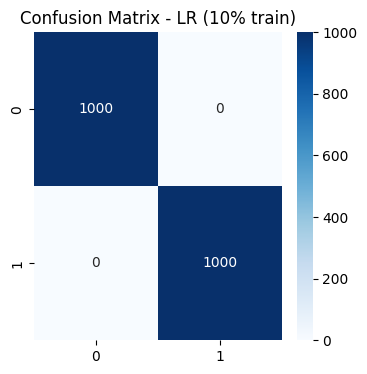

----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [10]:
# Dự đoán nhãn trên tập test
y_pred = model.predict(X_test)

# Tính độ chính xác
acc = accuracy_score(y_test, y_pred)
print(f"=== Logistic Regression (train 80% / test 20%) ===")
print("Accuracy:", acc)
print('-'*100)

# Vẽ ma trận nhầm lẫn (Confusion Matrix)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,  # in giá trị trong mỗi ô
    fmt='d',     # định dạng số nguyên
    cmap='Blues' # màu xanh
)
plt.title("Confusion Matrix - LR (10% train)")
plt.show()
print('-'*100)

# Báo cáo chi tiết các chỉ số: precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

## Demo

In [11]:
# Demo dự đoán 1 câu mới
sample = ["the service was insanely good, loved every second"]
print("Sentence", sample[0])

# Biến đổi câu mới thành vector TF-IDF (dùng cùng vectorizer đã fit)
sample = vectorizer.transform(sample)

# Dự đoán nhãn (positive/negative)
print("Predicted:", model.predict(sample)[0])

Sentence the service was insanely good, loved every second
Predicted: 1


## 7. Giao diện

### Lưu mô hình

In [12]:
import joblib

# lưu mô hình đã huấn luyện
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Mô hình đã được lưu")

Mô hình đã được lưu


### Xử lý thư viện

In [13]:
# chạy code này để tải thư viện
!pip install streamlit
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 121.3 MB/s eta 0:00:00


### Viết giao diện

In [14]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Cấu hình trang
st.set_page_config(page_title="Sentiment Analysis App", page_icon="⚡", layout="wide")

# Load model và vectorizer
@st.cache_resource
def load_model():
    model = joblib.load('sentiment_model.pkl')
    vectorizer = joblib.load('vectorizer.pkl')
    return model, vectorizer

model, vectorizer = load_model()

# Sidebar
st.sidebar.title("⚡ Sentiment Analysis")
st.sidebar.markdown("**Điều hướng**")
page = st.sidebar.radio("", ["🔴 Dashboard", "📝 Test Demo", "📤 Upload CSV"])

# Header
st.title("⚡ Sentiment Analysis App")
st.markdown("*Ứng dụng này phân loại cảm xúc **Positive/Negative** từ comment phim.*")

# ===== DASHBOARD =====
if page == "🔴 Dashboard":
    st.markdown("## 📷 Mô hình")

    col1, col2, col3 = st.columns(3)

    with col1:
        st.markdown("### 📦 Mô hình")
        st.write("**Logistic Regression**")

    with col2:
        st.markdown("### 📊 Vectorizer")
        st.write("**TF-IDF**")

    with col3:
        st.markdown("### ✅ Độ chính xác")
        st.write("**~90%+**")

    st.markdown("---")
    st.markdown("## ⚡ Tính năng chính")

    col4, col5 = st.columns(2)

    with col4:
        st.markdown("### 📌 📝 Test Demo")
        st.info("Nhập comment và dự đoán cảm xúc ngay.")

    with col5:
        st.markdown("### 📌 📤 Upload CSV")
        st.info("Upload file chứa nhiều comment để phân tích hàng loạt.")

# ===== TEST DEMO =====
elif page == "📝 Test Demo":
    st.markdown("## 📝 Test Demo")

    user_input = st.text_area("Nhập comment của bạn để dự đoán cảm xúc:", height=100)

    if st.button("Dự đoán"):
        if user_input.strip():
            # Xử lý văn bản
            text_vec = vectorizer.transform([user_input])
            prediction = model.predict(text_vec)[0]

            # Hiển thị kết quả
            if prediction == 1:
                st.success("✅ **Positive** - Comment tích cực!")
            else:
                st.error("❌ **Negative** - Comment tiêu cực!")
        else:
            st.warning("Vui lòng nhập comment trước khi dự đoán.")

# ===== UPLOAD CSV =====
elif page == "📤 Upload CSV":
    st.markdown("## 📤 Upload CSV")
    st.info("Upload file chứa nhiều comment để phân tích tổng loạt.")

    uploaded_file = st.file_uploader("Chọn file CSV (cần có cột 'Text')", type=["csv"])

    if uploaded_file is not None:
        df_upload = pd.read_csv(uploaded_file)

        if 'Text' in df_upload.columns:
            st.write("### Dữ liệu đã tải lên:")
            st.dataframe(df_upload.head())

            if st.button("Phân tích"):
                # Dự đoán
                texts = df_upload['Text'].astype(str).tolist()
                texts_vec = vectorizer.transform(texts)
                predictions = model.predict(texts_vec)

                # Thêm cột kết quả
                df_upload['Sentiment'] = ['Positive' if p == 1 else 'Negative' for p in predictions]

                # Hiển thị kết quả
                st.write("### Kết quả phân tích:")
                st.dataframe(df_upload)

                # Thống kê
                st.write("### Thống kê:")
                sentiment_counts = df_upload['Sentiment'].value_counts()
                st.bar_chart(sentiment_counts)

                # Download
                csv = df_upload.to_csv(index=False).encode('utf-8')
                st.download_button(
                    label="📥 Tải xuống kết quả",
                    data=csv,
                    file_name='sentiment_results.csv',
                    mime='text/csv'
                )
        else:
            st.error("File CSV phải có cột 'Text'!")

Writing app.py


### Chạy App

In [ ]:
# Chạy Streamlit app trong Colab
from pyngrok import ngrok

# Xóa tunnel cũ nếu có
ngrok.kill()

# Thay YOUR_AUTH_TOKEN bằng authtoken của bạn từ https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("YOUR_NGROK_AUTHENTICATION_TOKEN") # ngrok Authtoken

# Tạo tunnel mới
public_url = ngrok.connect(8501)
print(f"🌐 App đang chạy tại: {public_url}")

# Chạy streamlit
!streamlit run app.py

🌐 App đang chạy tại: NgrokTunnel: "https://nonevanescent-unsafe-angelena.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.24.217:8501

2025-11-27 13:14:11.392 Failed to schedule watch observer for path /content
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/streamlit/watcher/event_based_path_watcher.py", line 188, in watch_path
    folder_handler.watch = self._observer.schedule(
                           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/watchdog/observers/api.py", line 312, in schedule
    emitter.start()
  File "/usr/local/lib/python3.12/dist-packages/watchdog/utils/__init__.py", line 75, in start
    self.on_thread_start()
  File "/usr/local/lib/python3.12/dist-packages/watchdog/observers/inotify.py", line 119, in on_thread_start
    self._inotify = Inot